# DMD on two sinusoids

This notebook explores the use of Dynamic Mode Decomposition (DMD) to extract two sinusoids from a noisy signal. The signal is generated by summing two sinusoids with different frequencies and amplitudes, and adding Gaussian noise. The DMD algorithm is then applied to the signal to extract the two sinusoids.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator

Use the SignalGenerator class to generate the signal that will be fed to the DMD algorithm.

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=60)
signal_generator.add_sinusoid1(a=4, omega=0.5, k=2.5)
signal_generator.add_sinusoid2(a=2.5, omega=4)
signal_generator.add_noise(random_seed=42, noise_std=0.2)

In [3]:
print(f"Signal shape: {signal_generator.signal.shape}")
print(f"Time-vector shape: {signal_generator.t.shape}")
print(f"Spatial-vector shape: {signal_generator.x.shape}")

Signal shape: (500, 100)
Time-vector shape: (500,)
Spatial-vector shape: (100,)


Plot the two sinusoids making up the signal and the noisy signal itself.

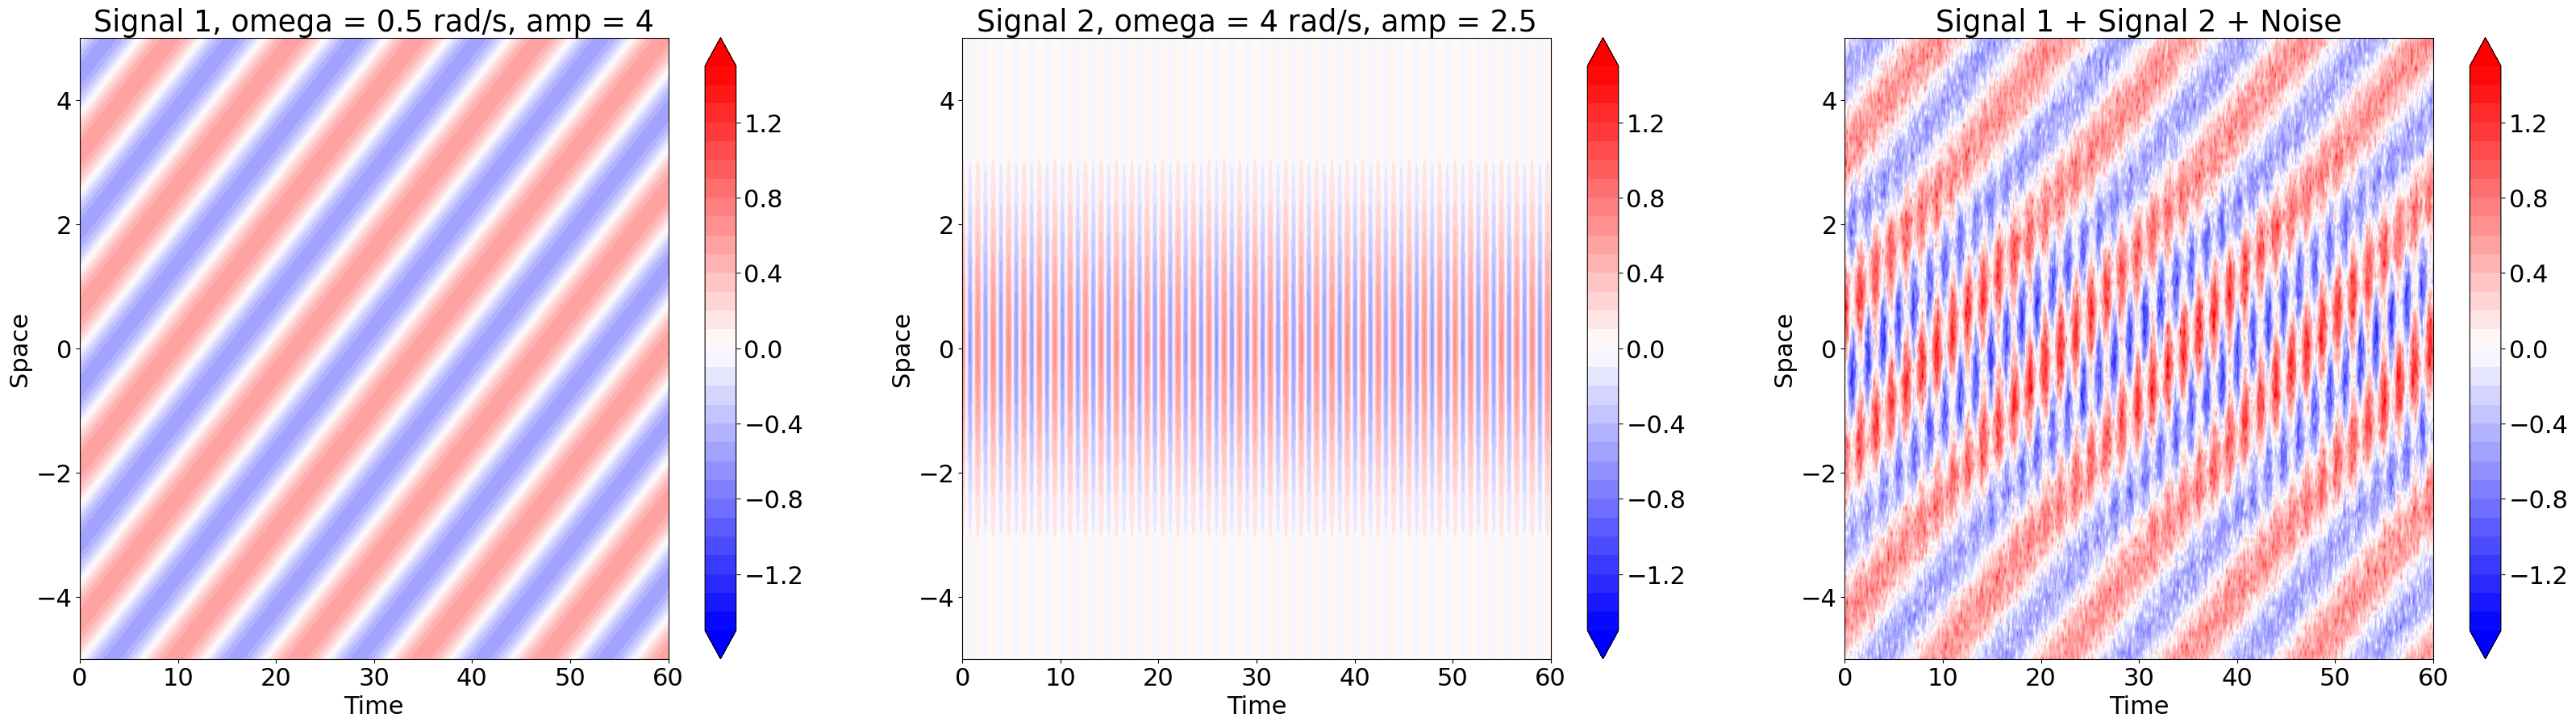

In [4]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s, amp = {signal_generator.components[0]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s, amp = {signal_generator.components[1]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Signal 1 + Signal 2 + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Application of DMD

Here we will apply Algorithms 2 and 3 from Askham and Kutz (2018) to the noisy signal. Note we will constrain the eigenvalues to the imaginary axis (i.e. pure oscillations) and we will enforce that the eigenvalues are always present with their complex conjugate.

In [5]:
svd_rank = 4  # the signal has two components, so we need 4 DMD modes to capture them
delay = 2  # apply time delay embedding to the data (usually delay=2 works well)

Algorithm 2: DMD is applied directly to the data, without an apriori SVD

In [6]:
optdmd2 = BOPDMD(
    svd_rank=svd_rank,
    num_trials=0,
    use_proj=False,
    eig_constraints={"imag", "conjugate_pairs"},
    varpro_opts_dict={"verbose": True})
delay_optdmd2 = hankel_preprocessing(optdmd2, d=delay)

Algorithm 3: SVD is applied to the data before DMD is applied

In [7]:
optdmd3 = BOPDMD(
    svd_rank=svd_rank,
    num_trials=0,
    use_proj=True,
    eig_constraints={"imag", "conjugate_pairs"},
    varpro_opts_dict={"verbose": True})
delay_optdmd3 = hankel_preprocessing(optdmd3, d=delay)

Fit the DMD model to 80% of the data and predict the remaining 20%. 

In [8]:
# fit DMD model to 80% of the temporal samples
train_frac = 0.8
f_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
f_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

t_delay = t_train[:-delay+1]  # time vector for the delay embedded data

In [9]:
delay_optdmd2.fit(f_train.T, t=t_delay)

Step 1 Error 0.5706480117469288 Lambda 0.3333333333333333
Step 2 Error 0.49332769665120124 Lambda 0.1111111111111111
Step 3 Error 0.4083651695162039 Lambda 0.037037037037037035
Step 4 Error 0.395223777138971 Lambda 0.012345679012345678
Step 5 Error 0.39518796001381873 Lambda 0.012122703068968062
Step 6 Error 0.3951879525348057 Lambda 0.02422000371395969
Step 7 Error 0.3951879525346129 Lambda 396.82054084951557
Stall detected: error reduced by less than 1e-12 times the error at the previous step. Iteration 7. Current error 0.3951879525346129. Consider increasing tol or decreasing eps_stall.


/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [10]:
delay_optdmd3.fit(f_train.T, t=t_delay, )

Step 1 Error 0.452173859050898 Lambda 0.3333333333333333
Step 2 Error 0.32560208031986626 Lambda 0.1111111111111111
Step 3 Error 0.12486901182334623 Lambda 0.037037037037037035
Step 4 Error 0.06226514842543278 Lambda 0.012345679012345678
Step 5 Error 0.06209932261725415 Lambda 0.0123456527799116
Step 6 Error 0.06209931500993106 Lambda 0.02468784129715619
Step 7 Error 0.06209931500124524 Lambda 202.2427959063035
Step 8 Error 0.06209931500061489 Lambda 404.4855866999263
Step 9 Error 0.06209931496200806 Lambda 808.9703993896013
Step 10 Error 0.06209931492539316 Lambda 1617.9382564629273
Step 11 Error 0.062099314910808674 Lambda 3235.8712311047216
Step 12 Error 0.062099314906736806 Lambda 6471.732385293674
Step 13 Error 0.0620993149056941 Lambda 12943.445053064284
Step 14 Error 0.06209931490543203 Lambda 25886.85093355152
Step 15 Error 0.062099314905366326 Lambda 51773.623543277936
Step 16 Error 0.062099314905349985 Lambda 103547.09132150472
Stall detected: error reduced by less than 1e-12

Plot the results for Algorithm 2

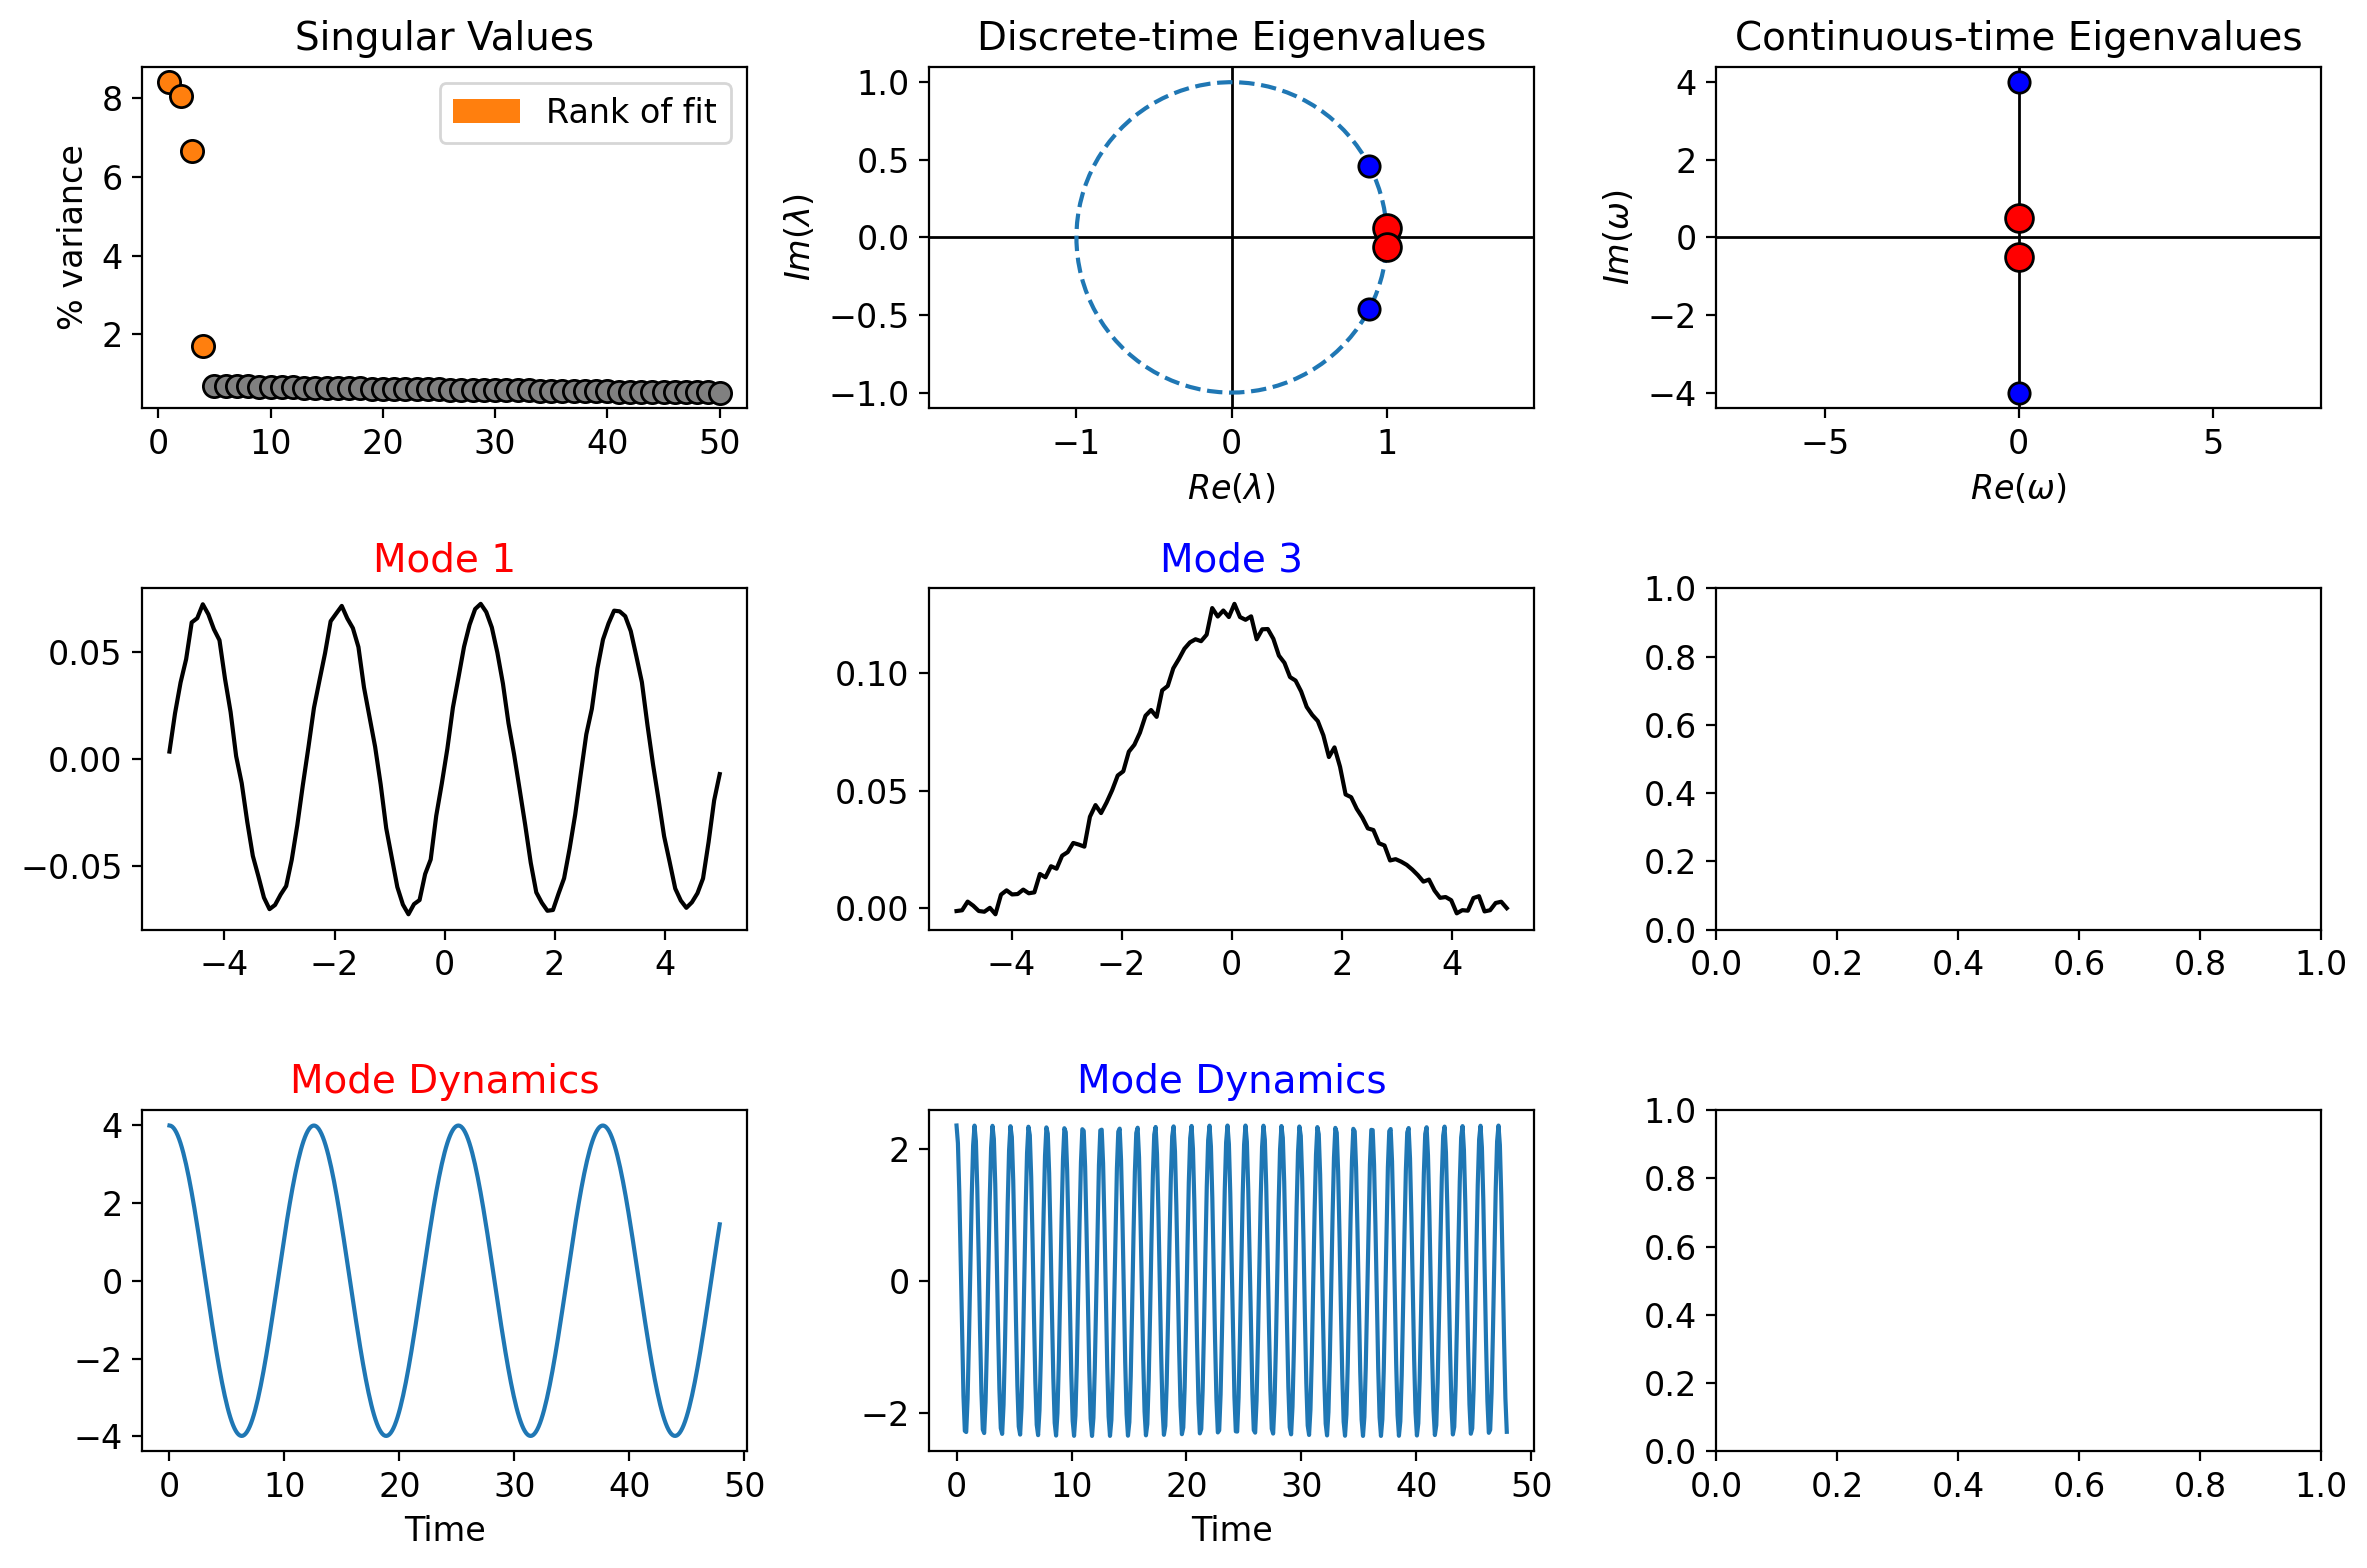

In [11]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd2, x=signal_generator.x, d=delay, index_modes=[0, 2])

Inspect the predicted mode amplitudes and eigenvalues for Algorithm 2. As can be seen, the DMD algorithm is able to extract the two sinusoids from the noisy signal, and the captured amplitudes and frequencies are close to the true values. Note that `sinusoid2` of `SignalGenerator` is a Gaussian pulse, and the amplitude parameter is actually the area under the curve (so we don't expect the amplitude captured by DMD to be exactly the same as the user input). 

In [12]:
sorted_index = np.argsort(delay_optdmd2.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd2.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd2.eigs[sorted_index]}")

Amplitudes: [3.98692069 3.98692069 2.34815461 2.34815461]
Eigenvalues: [ 0.+0.50012547j -0.-0.50012547j  0.+3.99964622j -0.-3.99964622j]


Do the same for Algorithm 3

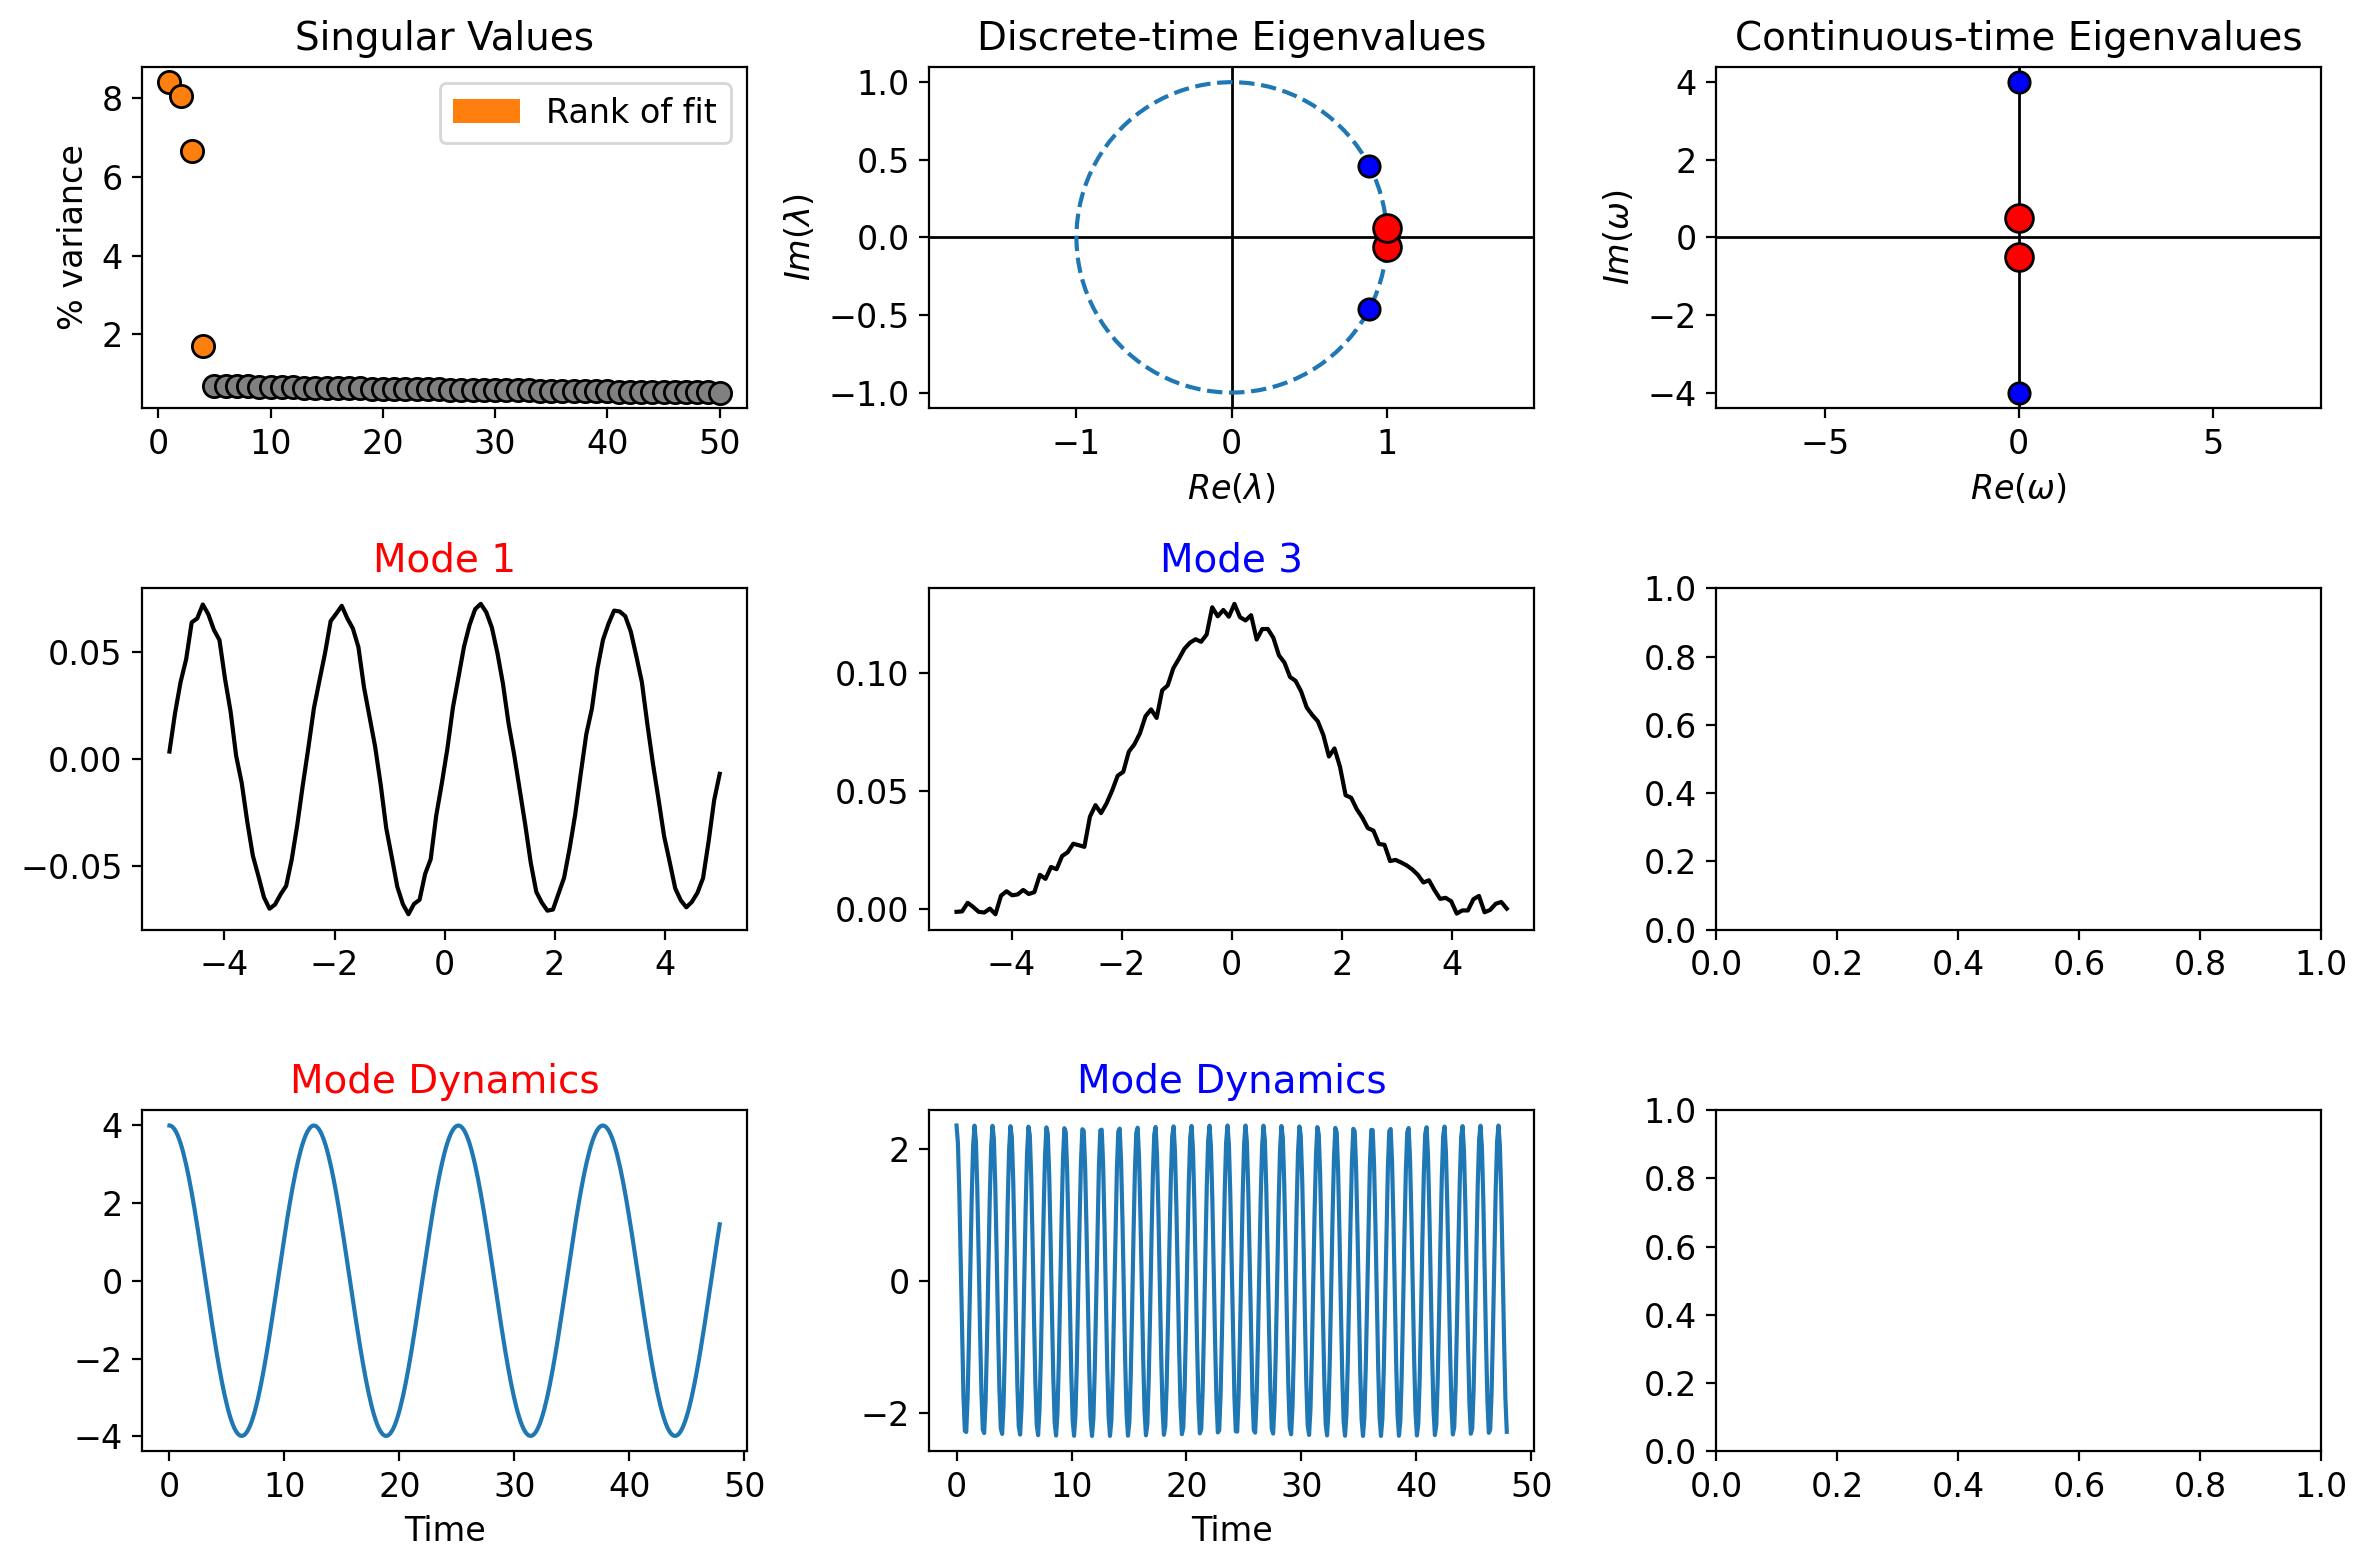

In [13]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd3, x=signal_generator.x, d=delay, index_modes=[0, 2])

In [14]:
sorted_index = np.argsort(delay_optdmd3.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd3.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd3.eigs[sorted_index]}")

Amplitudes: [3.98691334 3.98691334 2.34801272 2.34801272]
Eigenvalues: [-0.-0.50012549j  0.+0.50012549j -0.-3.9996482j   0.+3.9996482j ]


Now that we have the DMD models, produce the forecasts and compare to the true signal we saved for validation.

Forecast with Algorithm 2

In [15]:
forecast2 = delay_optdmd2.forecast(t_test)
forecast2 = forecast2[:signal_generator.x.shape[0], :]  # note that need to do this because of the time delay embedding
forecast2 = forecast2.T
forecast2 = forecast2.real

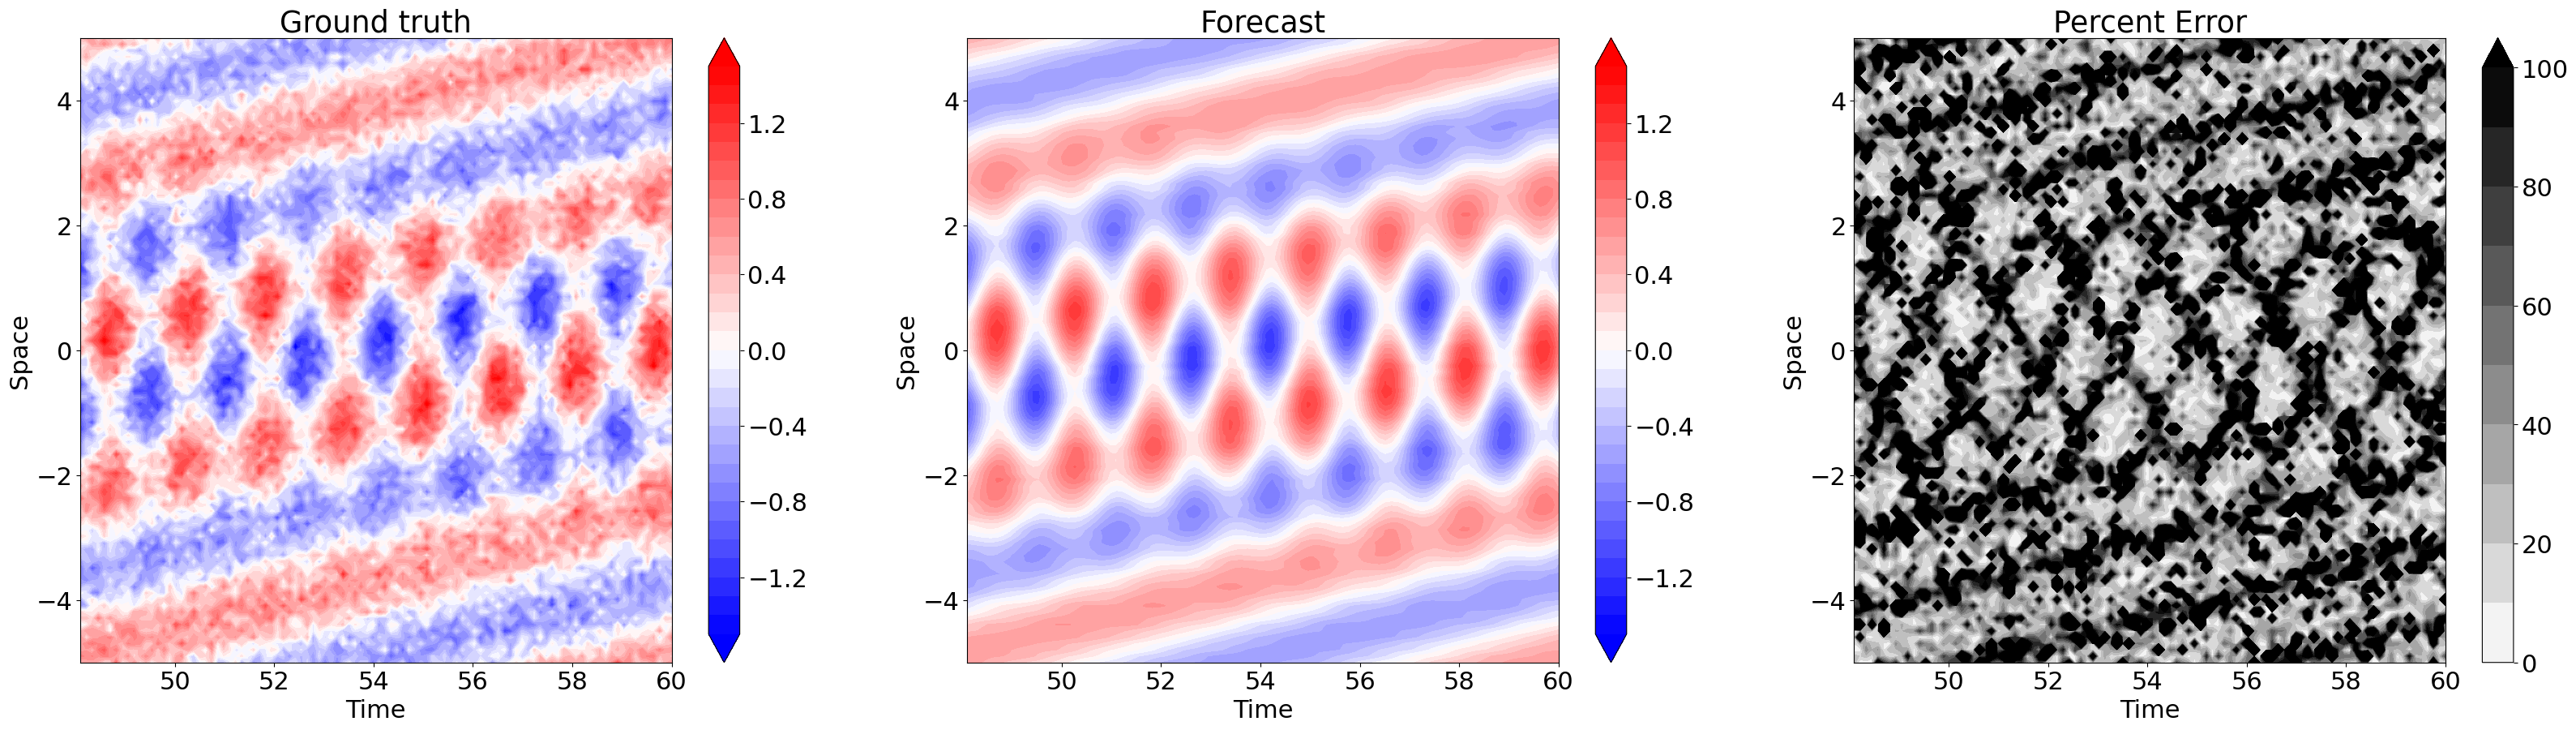

In [16]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast2, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast2) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

Forecast with Algorithm 3

In [17]:
forecast3 = delay_optdmd3.forecast(t_test)
forecast3 = forecast3[:signal_generator.x.shape[0], :]  # note that need to do this because of the time delay embedding
forecast3 = forecast3.T
forecast3 = forecast3.real

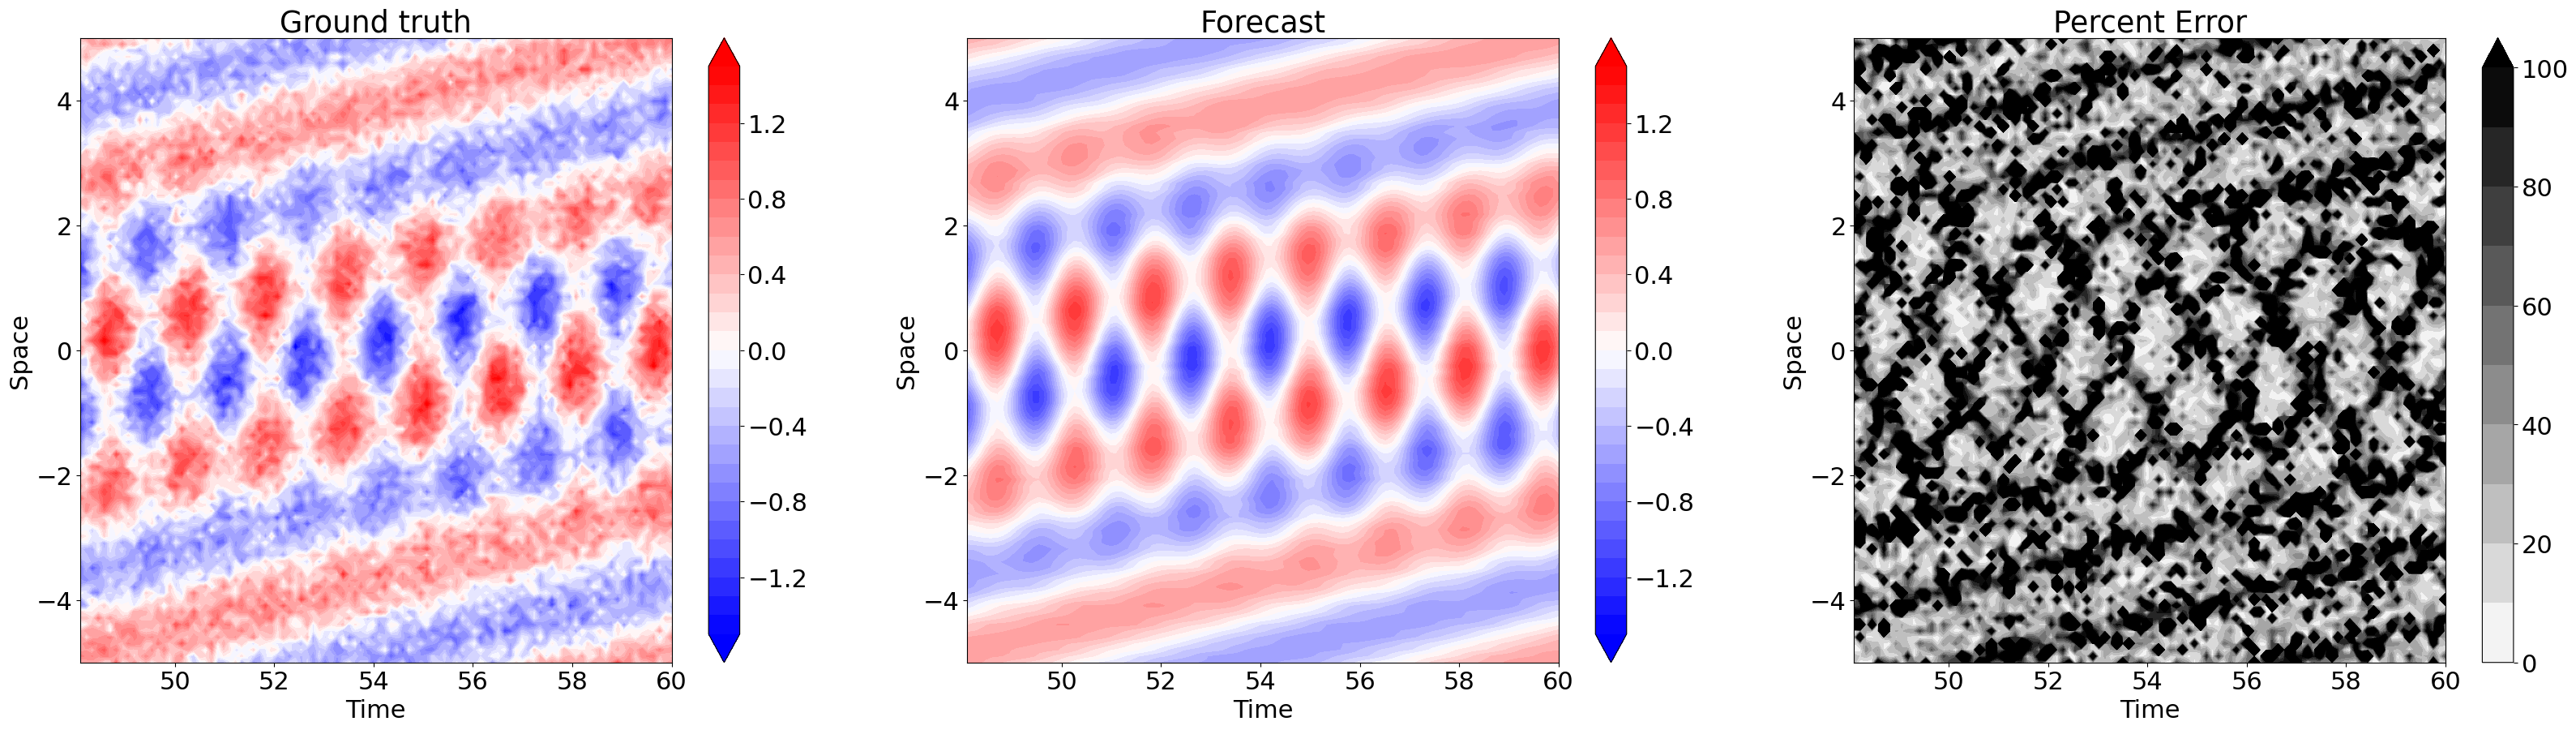

In [18]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast3, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast3) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Conclusion
Both algorithms 2 and 3 are able to extract the two sinusoids from the noisy signal and produce good quality forecasts.